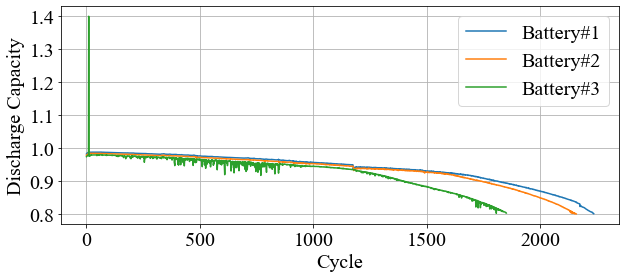

[InFo] Double Bacon Watts Model - Knee-Onset:  1684


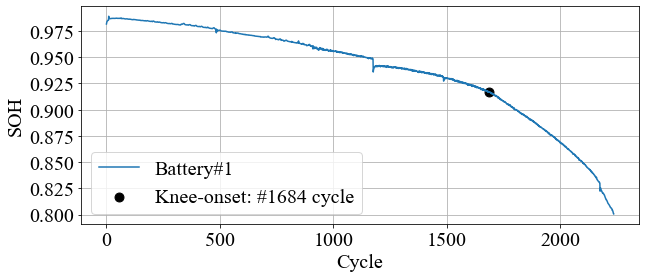

[InFo] Update Model -> Previous Error: [4448], Current Error: [2547.511263], Length Error: [1452.000000]
[InFo] Model Hyperparameters are -> XStamps: [ 23], YStamps: [  2], HiddenSize: [114], BatchSize: [ 45], Dropout: [0.069103], Epoch: [645]


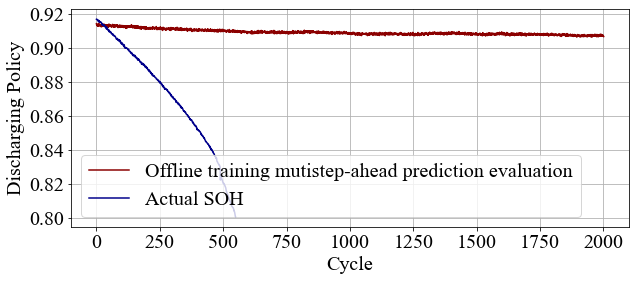

[InFo] Update Model -> Previous Error: [2547], Current Error: [1421.609981], Length Error: [451.000000]
[InFo] Model Hyperparameters are -> XStamps: [ 19], YStamps: [  1], HiddenSize: [ 44], BatchSize: [ 43], Dropout: [0.046329], Epoch: [769]


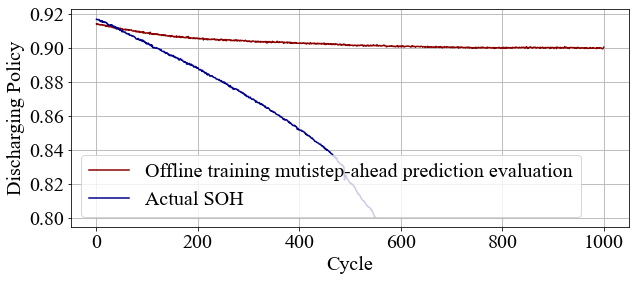

[InFo] Update Model -> Previous Error: [1421], Current Error: [877.203731], Length Error: [451.000000]
[InFo] Model Hyperparameters are -> XStamps: [ 20], YStamps: [  1], HiddenSize: [ 82], BatchSize: [ 88], Dropout: [0.041059], Epoch: [404]


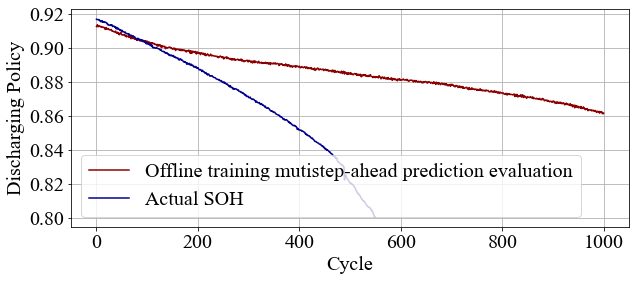

[InFo] Update Model -> Previous Error: [ 877], Current Error: [577.800738], Length Error: [451.000000]
[InFo] Model Hyperparameters are -> XStamps: [ 10], YStamps: [  1], HiddenSize: [120], BatchSize: [  9], Dropout: [0.054192], Epoch: [374]


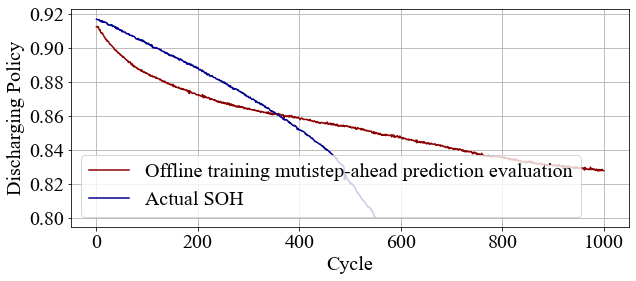

[InFo] Update Model -> Previous Error: [ 577], Current Error: [285.500001], Length Error: [269.000000]
[InFo] Model Hyperparameters are -> XStamps: [ 16], YStamps: [  7], HiddenSize: [110], BatchSize: [ 41], Dropout: [0.057729], Epoch: [734]


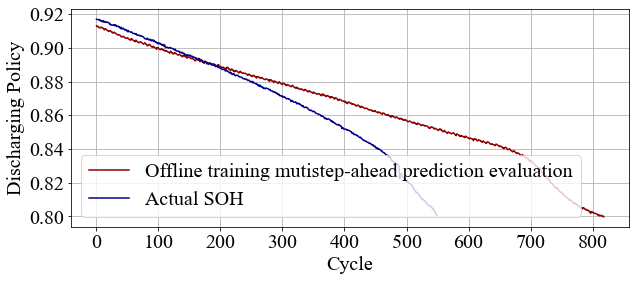

[InFo] Update Model -> Previous Error: [ 285], Current Error: [35.200001], Length Error: [23.000000]
[InFo] Model Hyperparameters are -> XStamps: [ 13], YStamps: [  1], HiddenSize: [ 70], BatchSize: [ 13], Dropout: [0.053768], Epoch: [731]


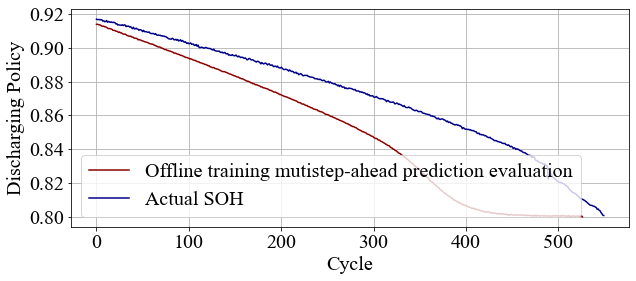

OptParam: OptXStamp:  13// OptYStamp:   1// OptHiddenSize:  70// OptBatchSzie:  13// OptDropoutRate: 0.000000// OptEpoch: 731


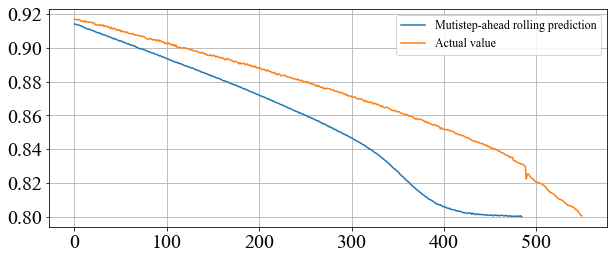

[InFo] Model tuning finished Time: [58.80198723706935 hours]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw
from scipy.optimize import differential_evolution
import torch
import torch.nn as nn
import torch.utils.data as data_
import os, random, time, joblib
os.environ["CUDA_LAUNCH_BLOCKING"]= "1"
np.random.seed(123)
random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.cuda.manual_seed_all(123)
torch.backends.cudnn.benchmark= False
torch.backends.cudnn.deterministic= True
plt.rcParams["font.family"] = "Times New Roman"
torch.cuda.empty_cache()
Device= "cuda" if torch.cuda.is_available() else "cpu"
class ModelOptimization:
    def __init__(self, SingleVariateTrainX, FeatureGenerationMethod, TorchModelStructure, EvaluationMethod, XScaler, YScaler, Device= "cuda", RollingPredictionVisualization= True):
        self.SingleVariateTrainX= SingleVariateTrainX
        self.TorchModelStructure= TorchModelStructure
        self.Device= Device
        self.EvaluationMethod= EvaluationMethod
        self.XScaler= XScaler
        self.YScaler= YScaler
        self.FeatureGenerationMethod= FeatureGenerationMethod
        self.InitOptimizationLoss= None
        self.RollingPredictionVisualization= RollingPredictionVisualization
        self.OptimizationError= []
    def DeepLearningTrochTraining(self, XStamps, YStamps, HiddenSize, BatchSzie, DropoutRate, Epoch):
        XScaler= self.XScaler
        YScaler= self.YScaler
        TrainX, TrainY= self.FeatureGenerationMethod(SingleVariate= self.SingleVariateTrainX, XTimeStamps= XStamps, YTimeStamps= YStamps)
        TrainX, TrainY= XScaler.fit_transform(TrainX), YScaler.fit_transform(TrainY)
        TrainX, TrainY= torch.FloatTensor(TrainX.reshape(-1, XStamps, 1)), torch.FloatTensor(TrainY)
        DeepLearningModel= self.TorchModelStructure(HiddenSize= [1, HiddenSize, YStamps], DropRate= DropoutRate, NumLstmLayers= 2).to(self.Device)
        TensorLoader= data_.TensorDataset(TrainX, TrainY)
        TensorLoader= data_.DataLoader(TensorLoader, batch_size= BatchSzie, shuffle= True)
        EpochLoss= []; EarlyStop= {"Iteration": 0, "LossValue": 10000, "MaxIteration": 30, "LastIteration": 0}
        LossFunction= torch.nn.MSELoss()
        Optimizer= torch.optim.Adam(DeepLearningModel.parameters(), lr= 0.01)
        for i_epoch in range(1, Epoch):
            DeepLearningModel.train()
            BatchLoss= []
            for _, data in enumerate(TensorLoader):
                InData, OutData= data
                InData, OutData= InData.to(self.Device), OutData.to(self.Device)
                Optimizer.zero_grad()
                PredictedOutData= DeepLearningModel(InData)
                Loss= LossFunction(PredictedOutData, OutData)
                BatchLoss.append(np.sum(Loss.data.cpu().numpy()))
                Loss.backward()
                Optimizer.step()
            # if (i_epoch % 10)== 0:
                # print("[InFo] Model Training -> Epoch: [%4d], Loss: [%2.6f]"%(i_epoch, np.sum(Loss.data.cpu().numpy())))
            DeepLearningModel.train()
            BatchLoss= round(np.mean(BatchLoss), 6)
            EpochLoss.append(BatchLoss)
            if BatchLoss <= EarlyStop["LossValue"]:
                EarlyStop["LossValue"]= BatchLoss
                EarlyStop["Iteration"]= 0
                EarlyStop["LastIteration"]= i_epoch
            else:
                EarlyStop["Iteration"]+= 1
                if EarlyStop["Iteration"] == EarlyStop["MaxIteration"]:
                    # print("[InFo] Model Training Ealry Stop -> Epoch: [%4d], Loss: [%2.6f]"%(EarlyStop["LastIteration"], EarlyStop["LossValue"]))
                    break
        DeepLearningModel.eval()
        TrainX= TrainX.data.cpu().numpy().reshape(-1, XStamps)
        TrainX= XScaler.inverse_transform(TrainX)
        MutipleStepsRollingPredictionResults= self.EvaluationMethod(XStamps= XStamps, YStamps= YStamps, TrainingData= TrainX, DeepLearningModel= DeepLearningModel, NormalizorX= XScaler, NormalizorY= YScaler, StoppingPredictionIteration= 1000)
        DTWDistance= round(dtw.distance(self.SingleVariateTrainX, MutipleStepsRollingPredictionResults), 4)* 1000
        DataLenght= np.abs(len(self.SingleVariateTrainX)- len(MutipleStepsRollingPredictionResults))
        LastPointMSE= (self.SingleVariateTrainX[-1]- MutipleStepsRollingPredictionResults[-1])** 2
        if DataLenght <= 10:
            ThreePerformanceMetric= DTWDistance* 10+ DataLenght+ LastPointMSE
        else:
            ThreePerformanceMetric= DTWDistance+ DataLenght+ LastPointMSE
        self.OptimizationError.append(ThreePerformanceMetric)
        if self.InitOptimizationLoss== None:
            torch.save(DeepLearningModel, os.path.join(os.getcwd(), "DLModelCheckPoint", "OptimizationModel.pth"))
            self.InitOptimizationLoss= ThreePerformanceMetric
        elif self.InitOptimizationLoss>= ThreePerformanceMetric:
            print("[InFo] Update Model -> Previous Error: [%4d], Current Error: [%2.6f], Length Error: [%4.6f]"%(self.InitOptimizationLoss, ThreePerformanceMetric, DataLenght))
            print("[InFo] Model Hyperparameters are -> XStamps: [%3d], YStamps: [%3d], HiddenSize: [%3d], BatchSize: [%3d], Dropout: [%2.6f], Epoch: [%3d]"%(self.XStamps, self.YStamps, self.HiddenSize, self.BatchSzie, self.DropoutRate, self.Epoch))
            torch.save(DeepLearningModel, os.path.join(os.getcwd(), "DLModelCheckPoint", "OptimizationModel.pth"))
            joblib.dump(XScaler, os.path.join(os.getcwd(), "NormalizerXY", "NormalizerX"))
            joblib.dump(YScaler, os.path.join(os.getcwd(), "NormalizerXY", "NormalizerY"))
            self.InitOptimizationLoss= ThreePerformanceMetric
            if self.RollingPredictionVisualization!= False:
                plt.figure(figsize= (10, 4))
                # plt.title("Mutiple Steps Model Rolling Prediction (Trained Model)", fontsize= 20, fontweight= "bold")
                plt.plot(np.arange(0, len(MutipleStepsRollingPredictionResults)), MutipleStepsRollingPredictionResults, label= "Offline training mutistep-ahead prediction evaluation", color= "darkred")
                plt.plot(np.arange(0, len(self.SingleVariateTrainX)), self.SingleVariateTrainX, label= "Actual SOH", color= "darkblue")
                plt.grid(True)
                plt.xticks(fontsize= 20)
                plt.yticks(fontsize= 20)
                plt.xlabel("Cycle", fontsize= 20)
                plt.ylabel("Discharging Policy", fontsize= 20)
                plt.legend(loc= "best", fontsize= 20)
                plt.show()
        else:
            pass
        del DeepLearningModel, XScaler, YScaler
        return ThreePerformanceMetric
    def OptimizationProcess(self, HyperparametersBounds):
        self.XStamps= int(HyperparametersBounds[0])
        self.YStamps= int(HyperparametersBounds[1])
        self.HiddenSize= int(HyperparametersBounds[2])
        self.BatchSzie= int(HyperparametersBounds[3])
        self.DropoutRate= float(HyperparametersBounds[4])
        self.Epoch= int(HyperparametersBounds[5])
        ThreePerformanceMetric= self.DeepLearningTrochTraining(self.XStamps, self.YStamps, self.HiddenSize, self.BatchSzie, self.DropoutRate, self.Epoch)
        return ThreePerformanceMetric
    def OptimizationProcessMainRun(self, ParamBounds, OptMaxiter, Visualization= True):
        self.OptimizationResults= differential_evolution(self.OptimizationProcess, ParamBounds, maxiter= OptMaxiter)
        OptXStamps= int(self.OptimizationResults.x[0])
        OptYStamps= int(self.OptimizationResults.x[1])
        OptHiddenSize= int(self.OptimizationResults.x[2])
        OptBatchSzie= int(self.OptimizationResults.x[3])
        OptDropoutRate= int(self.OptimizationResults.x[4])
        OptEpoch= int(self.OptimizationResults.x[5])
        print("OptParam: OptXStamp: %3d// OptYStamp: %3d// OptHiddenSize: %3d// OptBatchSzie: %3d// OptDropoutRate: %2.6f// OptEpoch: %3d"%(OptXStamps, 
        OptYStamps, OptHiddenSize, OptBatchSzie, OptDropoutRate, OptEpoch))
        OptimizedModel= torch.load(os.path.join(os.getcwd(), "DLModelCheckPoint", "OptimizationModel.pth"))
        OptimizedModel.eval()
        TrainX, TrainY= self.FeatureGenerationMethod(SingleVariate= self.SingleVariateTrainX, XTimeStamps= OptXStamps, YTimeStamps= OptYStamps)
        TrainX, TrainY= self.XScaler.fit_transform(TrainX), self.YScaler.fit_transform(TrainY)
        TrainX= TrainX.reshape(-1, OptXStamps)
        TrainX= self.XScaler.inverse_transform(TrainX)
        MutipleStepsRollingPredictionResults= self.EvaluationMethod(XStamps= OptXStamps, YStamps= OptYStamps, TrainingData= TrainX, 
        DeepLearningModel= OptimizedModel, NormalizorX= self.XScaler, NormalizorY= self.YScaler, StoppingPredictionIteration= 1000)
        if Visualization!= False:
            plt.figure(figsize= (10, 4))
            plt.plot(np.arange(0, len(MutipleStepsRollingPredictionResults)), MutipleStepsRollingPredictionResults, label= "Mutistep-ahead rolling prediction")
            plt.plot(np.arange(0, len(self.SingleVariateTrainX)), self.SingleVariateTrainX, label= "Actual value")
            plt.legend(loc= "best", fontsize= 12)
            plt.xticks(fontsize= 20)
            plt.yticks(fontsize= 20)
            plt.grid(True)
            plt.show()
        return MutipleStepsRollingPredictionResults

class BiLstmMWithAttention(nn.Module):
    def __init__(self, HiddenSize, DropRate, NumLstmLayers):
        super(BiLstmMWithAttention, self).__init__()
        self.HiddenSzie= HiddenSize
        self.DropRate= DropRate
        self.NumLstmLayers= NumLstmLayers
        if self.NumLstmLayers == 2:
            self.BilstmLayyer= nn.LSTM(input_size= self.HiddenSzie[0], hidden_size= self.HiddenSzie[1], num_layers= self.NumLstmLayers, 
            batch_first= True, bidirectional= True, dropout= self.DropRate)
            self.DenseLayers= nn.Linear(self.HiddenSzie[1]* 2, self.HiddenSzie[2])
        else:
            self.BilstmLayyer= nn.LSTM(input_size= self.HiddenSzie[0], hidden_size= self.HiddenSzie[1], num_layers= self.NumLstmLayers, 
            batch_first= True, bidirectional= True, dropout= self.DropRate)
            self.DenseLayers= nn.Linear(self.HiddenSzie[1]* 1, self.HiddenSzie[2])
    def attention(self, Value, Quary):
        Scale= Quary.size(-1)** 0.5
        Hidden= torch.cat(( Quary[0], Quary[1]), dim= 1).unsqueeze(2)
        AttentionScore= torch.functional.F.softmax(torch.bmm(Value, Hidden).squeeze(2)/ Scale, 1)
        Value= torch.bmm(Value.transpose(1, 2), AttentionScore.unsqueeze(2)).squeeze(2)
        return Value, AttentionScore
    def forward(self, X):
        if self.NumLstmLayers== 2:
            H0= torch.rand(size= (self.NumLstmLayers * 2, X.size(0), self.HiddenSzie[1])).to(Device)
            C0= torch.rand(size= (self.NumLstmLayers * 2, X.size(0), self.HiddenSzie[1])).to(Device)
        else:
            H0= torch.rand(size= (self.NumLstmLayers* 1, X.size(0), self.HiddenSzie[1])).to(Device)
            C0= torch.rand(size= (self.NumLstmLayers * 1, X.size(0), self.HiddenSzie[1])).to(Device)
        Out, (Hn, Cn) = self.BilstmLayyer(X, (H0, C0))
        Out, _= self.attention(Out, Hn)
        Out= self.DenseLayers(Out)
        return Out

def MutipleStepAheadFeatureGeneration(SingleVariate, XTimeStamps, YTimeStamps):
    if XTimeStamps< YTimeStamps:
        raise ValueError("XTimeStamps should be larger than YTimeStamps.")
    Input= []; Target= []
    for Tindex in range(0, len(SingleVariate)- XTimeStamps):
        Xindex= SingleVariate[Tindex: Tindex+ XTimeStamps]
        Input.append(Xindex)
    for Tindex in range(0+ XTimeStamps, len(SingleVariate)- YTimeStamps):
        Yindex= SingleVariate[Tindex: Tindex+ YTimeStamps]
        Target.append(Yindex)
    Input= np.array(Input); Target= np.array(Target)
    n= Target.shape[0]
    Input= Input[: n, :]
    return Input, Target

def BaconWattsKneeOpintModel(x, alpha0, alpha1, alpha2, x1):
    return alpha0 + alpha1*(x - x1) + alpha2*(x - x1)*np.tanh((x - x1) / 1e-8)

def DoubleBaconWattsModel(x, alpha0, alpha1, alpha2, alpha3, x0, x2):
    return alpha0 + alpha1*(x - x0) + alpha2*(x - x0)*np.tanh((x - x0)/1e-8) + alpha3*(x - x2)*np.tanh((x - x2)/1e-8)

def MutipleStepsRollingPredictionForOptimization(XStamps, YStamps, TrainingData, DeepLearningModel, NormalizorX, NormalizorY, StoppingPredictionIteration):
    DeepLearningModel.eval()
    with torch.no_grad():
        if XStamps== YStamps:
            MutipleStepPredictedValuesList= []
            ### the last row to training data will be used for online rollling predition
            LastRowTrainingData= TrainingData[0: 1, :]
            LastRowTrainingData= NormalizorX.transform(LastRowTrainingData)
            LastRowTrainingData= LastRowTrainingData.reshape(-1, TrainingData.shape[1], 1)
            LastRowTrainingData= torch.FloatTensor(LastRowTrainingData).to(Device)
            ### the first step prediction process
            MutipleStepPredictedValues= DeepLearningModel(LastRowTrainingData)
            MutipleStepPredictedValuesList+= list(list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel()))
            ### the next step prediction process
            for _ in range(0, StoppingPredictionIteration):
                NextMutipleStepInput= MutipleStepPredictedValues.data.cpu().numpy().reshape(-1, TrainingData.shape[1], 1)
                NextMutipleStepInput= torch.Tensor(NextMutipleStepInput).to(Device)
                ### next step
                MutipleStepPredictedValues= DeepLearningModel(NextMutipleStepInput)
                MutipleStepPredictedValuesList+= list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel())
                if len(np.where(np.array(MutipleStepPredictedValuesList)<= 0.800)[0]) != 0:
                    print("[InFo] The prediction results reach EOL discharge capacity")
                    break
                else:
                    pass
        else:
            MutipleStepPredictedValuesList= []
            ### the last row to training data will be used for online rollling predition
            LastRowTrainingData= TrainingData[0: 1, :]
            LastRowTrainingData= NormalizorX.transform(LastRowTrainingData)
            LastRowTrainingData= LastRowTrainingData.reshape(-1, TrainingData.shape[1], 1)
            LastRowTrainingData= torch.FloatTensor(LastRowTrainingData).to(Device)
            ### the first step prediction process
            MutipleStepPredictedValues= DeepLearningModel(LastRowTrainingData)
            MutipleStepPredictedValuesList+= list(list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel()))
            ### the next step prediction process
            for _ in range(0, StoppingPredictionIteration):
                NextMutipleStepInput= MutipleStepPredictedValues.data.cpu().numpy().ravel()
                NextMutipleStepInput= np.append(LastRowTrainingData.data.cpu().numpy().ravel()[YStamps: ], NextMutipleStepInput)
                NextMutipleStepInput= NextMutipleStepInput.reshape(-1, TrainingData.shape[1], 1)
                NextMutipleStepInput= torch.Tensor(NextMutipleStepInput).to(Device)
                ### next step
                MutipleStepPredictedValues= DeepLearningModel(NextMutipleStepInput)
                MutipleStepPredictedValuesList+= list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel())
                LastRowTrainingData= NextMutipleStepInput
                if len(np.where(np.array(MutipleStepPredictedValuesList)<= 0.800)[0]) != 0:
                    # print("[InFo] The prediction results reach EOL discharge capacity")
                    break
                else:
                    pass
    MutipleStepPredictedValuesList= np.array(MutipleStepPredictedValuesList)
    return MutipleStepPredictedValuesList

def MutipleStepsRollingPredictionForTargetData(XStamps, YStamps, TrainingData, DeepLearningModel, NormalizorX, NormalizorY, StoppingPredictionIteration):
    DeepLearningModel.eval()
    with torch.no_grad():
        if XStamps== YStamps:
            MutipleStepPredictedValuesList= []
            ### the last row to training data will be used for online rollling predition
            LastRowTrainingData= TrainingData[-1: , :]
            LastRowTrainingData= NormalizorX.transform(LastRowTrainingData)
            LastRowTrainingData= LastRowTrainingData.reshape(-1, TrainingData.shape[1], 1)
            LastRowTrainingData= torch.FloatTensor(LastRowTrainingData).to(Device)
            ### the first step prediction process
            MutipleStepPredictedValues= DeepLearningModel(LastRowTrainingData)
            MutipleStepPredictedValuesList+= list(list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel()))
            ### the next step prediction process
            for _ in range(0, StoppingPredictionIteration):
                NextMutipleStepInput= MutipleStepPredictedValues.data.cpu().numpy().reshape(-1, TrainingData.shape[1], 1)
                NextMutipleStepInput= torch.Tensor(NextMutipleStepInput).to(Device)
                ### next step
                MutipleStepPredictedValues= DeepLearningModel(NextMutipleStepInput)
                MutipleStepPredictedValuesList+= list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel())
                if len(np.where(np.array(MutipleStepPredictedValuesList)<= 0.800)[0]) != 0:
                    print("[InFo] The prediction results reach EOL discharge capacity")
                    break
                else:
                    pass
        else:
            MutipleStepPredictedValuesList= []
            ### the last row to training data will be used for online rollling predition
            LastRowTrainingData= TrainingData[-1: , :]
            LastRowTrainingData= NormalizorX.transform(LastRowTrainingData)
            LastRowTrainingData= LastRowTrainingData.reshape(-1, TrainingData.shape[1], 1)
            LastRowTrainingData= torch.FloatTensor(LastRowTrainingData).to(Device)
            ### the first step prediction process
            MutipleStepPredictedValues= DeepLearningModel(LastRowTrainingData)
            MutipleStepPredictedValuesList+= list(list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel()))
            ### the next step prediction process
            for _ in range(0, StoppingPredictionIteration):
                NextMutipleStepInput= MutipleStepPredictedValues.data.cpu().numpy().ravel()
                NextMutipleStepInput= np.append(LastRowTrainingData.data.cpu().numpy().ravel()[YStamps: ], NextMutipleStepInput)
                NextMutipleStepInput= NextMutipleStepInput.reshape(-1, TrainingData.shape[1], 1)
                NextMutipleStepInput= torch.Tensor(NextMutipleStepInput).to(Device)
                ### next step
                MutipleStepPredictedValues= DeepLearningModel(NextMutipleStepInput)
                MutipleStepPredictedValuesList+= list(NormalizorY.inverse_transform(MutipleStepPredictedValues.cpu().data.numpy()).ravel())
                LastRowTrainingData= NextMutipleStepInput
                if len(np.where(np.array(MutipleStepPredictedValuesList)<= 0.800)[0]) != 0:
                    print("[InFo] The prediction results reach EOL discharge capacity")
                    break
                else:
                    pass
    MutipleStepPredictedValuesList= np.array(MutipleStepPredictedValuesList)
    return MutipleStepPredictedValuesList

def FineTuneModelWeighsModule(FineTuneX, FineTuneY, PreTraindModel, FineTuneBatchSize, FineTuneEpoch, FinTuneLearningRate, EarlyStopEpoch, Device):
    global Sp
    FineTuneX, FineTuneY= torch.FloatTensor(FineTuneX), torch.FloatTensor(FineTuneY)
    TensorLoader= data_.TensorDataset(FineTuneX, FineTuneY)
    TensorLoader= data_.DataLoader(TensorLoader, batch_size= FineTuneBatchSize, shuffle= True)
    LossFunction= torch.nn.MSELoss()
    Optimizer= torch.optim.Adam(PreTraindModel.parameters(), lr= FinTuneLearningRate)
    EpochLoss= []; EarlyStop= {"Iteration": 0, "LossValue": 10000, "MaxIteration": EarlyStopEpoch, "LastIteration": 0}
    for i_epoch in range(1, FineTuneEpoch):
        PreTraindModel.train()
        BatchLoss= []
        for _, data in enumerate(TensorLoader):
            InData, OutData= data
            InData, OutData= InData.to(Device), OutData.to(Device)
            Optimizer.zero_grad()
            PredictedOutData= PreTraindModel(InData)
            Loss= LossFunction(PredictedOutData, OutData)
            BatchLoss.append(np.sum(Loss.data.cpu().numpy()))
            Loss.backward()
            Optimizer.step()
        if (i_epoch % 10)== 0:
            print("[InFo] Model Training -> Epoch: [%4d], Loss: [%2.6f]"%(i_epoch, np.sum(Loss.data.cpu().numpy())))
        PreTraindModel.train()
        BatchLoss= round(np.mean(BatchLoss), 6)
        EpochLoss.append(BatchLoss)
        torch.save(PreTraindModel, os.path.join(os.getcwd(), "ModelFinTuneCheckPoint", "Epoch"+ str(i_epoch)+ ".pth"))
        if BatchLoss <= EarlyStop["LossValue"]:
            EarlyStop["LossValue"]= BatchLoss
            EarlyStop["Iteration"]= 0
            EarlyStop["LastIteration"]= i_epoch
        else:
            EarlyStop["Iteration"]+= 1
            if EarlyStop["Iteration"] == EarlyStop["MaxIteration"]:
                print("[InFo] Model Training Ealry Stop -> Epoch: [%4d], Loss: [%2.6f]"%(EarlyStop["LastIteration"], EarlyStop["LossValue"]))
                break
    PreTraindModel= torch.load(os.path.join(os.getcwd(), "ModelFinTuneCheckPoint", "Epoch"+ str(EarlyStop["LastIteration"])+ ".pth"))
    plt.figure(figsize= (8, 4))
    plt.plot(np.arange(0, len(EpochLoss)), EpochLoss)
    plt.scatter(np.arange(0, len(EpochLoss)), EpochLoss, label= "loss (Sp: %s)"%(str(Sp)), s= 30, color= "darkblue", edgecolors= "black")
    plt.scatter(EarlyStop["LastIteration"], EpochLoss[EarlyStop["LastIteration"]], label= "Early stopping epoch", color= "red", s= 50)
    plt.grid(True)
    plt.xlabel("Epoch", fontsize= 15)
    plt.ylabel("Fine-tuning training loss", fontsize= 15)
    plt.legend(loc= "best", fontsize= 15)
    plt.xticks(fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.show()
    return PreTraindModel

if __name__ == "__main__":
    torch.cuda.empty_cache()
    MainPath= os.getcwd()
    FileName= "ChargingPolicy1.csv"
    with open(os.path.join(MainPath, FileName), "r") as file:
        ChargingPolicy1Data= pd.read_csv(open(os.path.join(MainPath, FileName)))
    ModelOptimizationProcess= True
    Sp= 0.888; EOL= 0.80
    OptXTimeStamps= 9; OptYtimeStamps= 2; OptBatchSize= 70; Epoch= 10000; LearningRate= 0.01; EarlyStopEpoch= 10
    plt.figure(figsize= (10, 4))
    plt.plot(ChargingPolicy1Data["Cycle"][ChargingPolicy1Data["#1_SOH"]>= EOL], ChargingPolicy1Data["#1_SOH"][ChargingPolicy1Data["#1_SOH"]>= EOL], label= "Battery#1")
    plt.plot(ChargingPolicy1Data["Cycle"][ChargingPolicy1Data["#2_SOH"]>= EOL], ChargingPolicy1Data["#2_SOH"][ChargingPolicy1Data["#2_SOH"]>= EOL], label= "Battery#2")
    plt.plot(ChargingPolicy1Data["Cycle"][ChargingPolicy1Data["#3_SOH"]>= EOL], ChargingPolicy1Data["#3_SOH"][ChargingPolicy1Data["#3_SOH"]>= EOL], label= "Battery#3")
    plt.grid(True)
    plt.xlabel("Cycle", fontsize= 20)
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlabel("Cycle", fontsize= 20)
    plt.ylabel("Discharge Capacity", fontsize= 20)
    plt.legend(loc= "best", fontsize= 20)
    plt.show()
    ### Source data uses for training LSTM-AT model
    Battery1= ChargingPolicy1Data[["Cycle", "#1_SOH"]]
    Battery1= Battery1[Battery1["#1_SOH"]>= EOL]
    Battery1= Battery1.dropna(axis= 0)
    Battery1DischargeCapacity= np.array(Battery1["#1_SOH"])
    Battery1Cycle= np.array(Battery1["Cycle"])
    ### Knee-onset computation
    ParameterBound= [1, -1e-4, -1e-4, len(Battery1DischargeCapacity)* 0.7]
    Coe, Cov= curve_fit(BaconWattsKneeOpintModel, Battery1Cycle, Battery1DischargeCapacity, ParameterBound)
    OptAlpha0, OptAlpha1, OptAlpha2, OptX1= Coe
    UpperX1, LowerX1= Coe[3]+ 1.96* np.diag(Cov)[3], Coe[3]- 1.96* np.diag(Cov)[3]
    ParameterBound= [OptAlpha0, OptAlpha1+ OptAlpha2/ 2, OptAlpha2, OptAlpha2/ 2, 0.8*OptX1, 1.1*OptX1]
    Coe, Cov= curve_fit(DoubleBaconWattsModel, Battery1Cycle, Battery1DischargeCapacity, ParameterBound)
    OptAlpha0, OptAlpha1, OptAlpha2, OptAlpha3, OptX0, OptX2= Coe
    UpperX1, LowerX1= Coe[4]+ 1.96* np.diag(Cov)[4], Coe[4]- 1.96* np.diag(Cov)[4]
    KneeOnsetByDoubleBaconWatts= round(OptX1)
    print("[InFo] Double Bacon Watts Model - Knee-Onset: ", KneeOnsetByDoubleBaconWatts)
    plt.figure(figsize= (10, 4))
    # plt.title("Charging Policy #3", fontsize= 20)
    plt.plot(Battery1Cycle, Battery1DischargeCapacity, label= "Battery#1")
    plt.scatter(Battery1Cycle[KneeOnsetByDoubleBaconWatts], Battery1DischargeCapacity[KneeOnsetByDoubleBaconWatts], 
    label= "Knee-onset: #%s cycle"%(KneeOnsetByDoubleBaconWatts), color= "black", s= 80)
    plt.grid(True)
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize= 20)
    plt.xlabel("Cycle", fontsize= 20)
    plt.ylabel("SOH", fontsize= 20)
    plt.legend(loc= "best", fontsize= 20)
    plt.show()
    if ModelOptimizationProcess== True:
        ### BiLSTM-AT model training and hyperparameters optimization
        SingleVariateTraningSet= Battery1DischargeCapacity[KneeOnsetByDoubleBaconWatts+ 1: ]
        ModelTuningStartTime= time.time()
        ModelOptimizaionModule= ModelOptimization(SingleVariateTrainX= SingleVariateTraningSet, TorchModelStructure= BiLstmMWithAttention, EvaluationMethod= MutipleStepsRollingPredictionForOptimization, FeatureGenerationMethod= MutipleStepAheadFeatureGeneration, XScaler= MinMaxScaler(), YScaler= MinMaxScaler(), Device= "cuda", RollingPredictionVisualization= True)
        ParamBounds= [(10, 24), (1, 9), (12, 128), (8, 128), (0.001, 0.1), (80, 1000)]
        MutipleStepsRollingPredictionResults= ModelOptimizaionModule.OptimizationProcessMainRun(ParamBounds= (ParamBounds), OptMaxiter= 20, Visualization= True)
        ModelTuningEndTime= time.time()
        print("[InFo] Model tuning finished Time: [%s hours]"%(str((ModelTuningEndTime- ModelTuningStartTime)/ 60/60)))
    else:
        ### Transfer learning process
        Battery2= ChargingPolicy1Data[["Cycle", "#2_SOH"]]
        Battery2= Battery2[Battery2["#2_SOH"]>= EOL]
        Battery2= Battery2.dropna(axis= 0)
        Battery2DischargeCapacity= np.array(Battery2["#2_SOH"])
        Battery2Cycle= np.array(Battery2["Cycle"])
        ### Online simulation process
        SourceDtaKneeOnsetValue= Battery1DischargeCapacity[KneeOnsetByDoubleBaconWatts]
        StopRule= 0.80; NowIndex= 0; SOHls= []; RulActivation= True; Tsp= None
        for Tindex in range(0, len(Battery2DischargeCapacity)):
            TargetSOH= Battery2DischargeCapacity[Tindex]
            SOHls.append(TargetSOH)
            if TargetSOH <= Sp and RulActivation== True:
                Tsp= len(SOHls)
                ### Knee-point computation
                ParameterBound= [1, -1e-4, -1e-4, len(SOHls)* 0.7]
                Coe, Cov= curve_fit(BaconWattsKneeOpintModel, np.arange(0, len(SOHls)), SOHls, ParameterBound)
                OptAlpha0, OptAlpha1, OptAlpha2, OptX1= Coe
                UpperX1, LowerX1= Coe[3]+ 1.96* np.diag(Cov)[3], Coe[3]- 1.96* np.diag(Cov)[3]
                KneePoint= round(OptX1)
                plt.figure(figsize= (10, 4))
                plt.title("Charging Policy #3", fontsize= 20)
                plt.plot(Battery2Cycle[: len(SOHls)], SOHls, label= "Battery#2 (online prediction)")
                plt.scatter(Battery2Cycle[len(SOHls)], Battery2DischargeCapacity[len(SOHls)], 
                label= "Tsp: #%s cycle"%(Tsp), color= "black", s= 50)
                plt.scatter(Battery2Cycle[KneePoint], Battery2DischargeCapacity[KneePoint], 
                label= "Knee-PointOnset: #%s cycle"%(KneePoint), color= "darkblue", s= 80)
                plt.grid(True)
                plt.xlabel("Cycle", fontsize= 20)
                plt.ylabel("SOH", fontsize= 20)
                plt.xticks(fontsize= 20)
                plt.yticks(fontsize= 20)
                plt.legend(loc= "best", fontsize= 20)
                plt.show()
                print("[InFo] Knee-point identification for target data: Index: [%3d]// SOH: [%2.6f]"%(Tindex, TargetSOH))
                ### Load model weights
                PreTraindModel= torch.load(os.path.join(os.getcwd(), "DLModelCheckPoint", "OptimizationModel.pth"))
                ### Frezzing BiLSTM-AT Layer process
                for param in PreTraindModel.BilstmLayyer.parameters():
                    param.requires_grad= False
                NormalizerX= joblib.load(os.path.join(os.getcwd(), "NormalizerXY", "NormalizerX"))
                NormalizerY= joblib.load(os.path.join(os.getcwd(), "NormalizerXY", "NormalizerY"))                
                SingleVarateSOHls= np.array(SOHls)[KneePoint: ]
                # OptParam: OptXStamp:   9// OptYStamp:   2// OptHiddenSize:  88// OptBatchSzie:  70// OptDropoutRate: 0.000000// OptEpoch: 745
                OptXTimeStamps= 9; OptYtimeStamps= 2; OptBatchSize= 70; Epoch= 10000; LearningRate= 0.01; EarlyStopEpoch= 10
                FineTuneX, FineTuneY= MutipleStepAheadFeatureGeneration(SingleVariate= SingleVarateSOHls, XTimeStamps= OptXTimeStamps, YTimeStamps= OptYtimeStamps)
                FineTuneX, FineTuneY= NormalizerX.transform(FineTuneX), NormalizerY.transform(FineTuneY)
                FineTuneX, FineTuneY= FineTuneX.reshape(-1, OptXTimeStamps, 1), FineTuneY
                FineTunePretrainModel= FineTuneModelWeighsModule(FineTuneX, FineTuneY, PreTraindModel, OptBatchSize, Epoch, LearningRate, EarlyStopEpoch, Device)
                FineTuneX, FineTuneY= FineTuneX.reshape(-1, OptXTimeStamps), FineTuneY
                FineTuneX, FineTuneY= NormalizerX.inverse_transform(FineTuneX), NormalizerY.inverse_transform(FineTuneY)
                TargetPredictedSOH= MutipleStepsRollingPredictionForTargetData(OptXTimeStamps, OptYtimeStamps, FineTuneX, FineTunePretrainModel, NormalizerX, NormalizerY, 1000)
                RulActivation= False
        plt.figure(figsize= (10, 4))
        plt.plot(Battery2Cycle[: Tsp], SOHls[: Tsp], label= "Actual Battery#8 (known)", color= "black")
        plt.plot(Battery2Cycle[Tsp: ], SOHls[Tsp: ], label= "Actual Battery#8 (unknown)", color= "darkblue")
        plt.scatter(Battery2Cycle[Tsp], Battery2DischargeCapacity[Tsp], label= "Tsp: #%s cycle"%(Tsp), color= "black", s= 80)
        plt.plot(np.arange(Tsp, Tsp+ len(TargetPredictedSOH)), TargetPredictedSOH, label= "Multiple step-ahead prediciton results")
        plt.hlines(EOL, Battery2Cycle[0], Battery2Cycle[-1], label= "EOL (SOH= %s)"%(str(Sp)), color= "red", ls= "--")
        plt.grid(True)
        plt.xticks(fontsize= 20)
        plt.yticks(fontsize= 20)
        plt.xlabel("Cycle", fontsize= 20)
        plt.ylabel("SOH", fontsize= 20)
        plt.legend(loc= "best", fontsize= 20)
        plt.show()
        ### RUL computation
        ActualRul= len(Battery2DischargeCapacity)- Tsp
        PredictedRul= len(TargetPredictedSOH)
        ActualEol= len(Battery2DischargeCapacity)
        PredictedEol= len(TargetPredictedSOH)+ Tsp
        print("[InFo] Actual RUL: [%4.6f] //Predicted RUL: [%4.6f]"%(ActualRul, PredictedRul))
        print("[InFo] Actual EOL: [%4.6f] //Predicted EOL: [%4.6f]"%(ActualEol, PredictedEol))
        print("[InFo] Predicted RUL Error: [%4.6f] \n[InFo] Predicted EOL Error: [%4.6f] \n[InFo] Relative Error: [%4.6f]"%(np.abs(ActualRul- PredictedRul)
        , np.abs(ActualEol- PredictedEol), (np.abs(ActualRul- PredictedRul)/ ActualRul)* 100), "%")